# Helmholtz 1D: Coarsening Operator Quality vs. TV Smoothing
* Discretization: 5-point (4th order).
* Fixed-domain problem; non-repetitive, so we generate TVs over entire domain.
* Fix aggregate size to $4$ points. Consider a certain aggregate in the domain (say, the first one).
* Observe beahviour vs. $\nu$:
  * Create relaxed TVs with $\nu$ Kaczmarz relaxation sweeps.
  * Create the coarsening operator $R$ using SVD. Observe singular value decay rate.
  * Observe two-level mini-cycle convergence factor before slowing down.

In [221]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Number of test vectors.
num_examples = 10
threshold = 0.1
kh = 0.5

## Coarsening Quality
We measure the gap between the second and third singular values as a function of the number of TV relaxation sweeps $\nu$. We force the aggregate size to be $4$.

nu  5 s [1.    0.257 0.17  0.059] Energy error [0.299 0.172 0.056 0.   ]
nu 10 s [1.    0.314 0.1   0.018] Energy error [0.314 0.097 0.017 0.   ]
nu 20 s [1.    0.373 0.073 0.006] Energy error [0.355 0.068 0.006 0.   ]
nu 40 s [1.    0.354 0.057 0.003] Energy error [0.338 0.054 0.003 0.   ]
nu 80 s [1.    0.331 0.042 0.002] Energy error [0.316 0.04  0.002 0.   ]


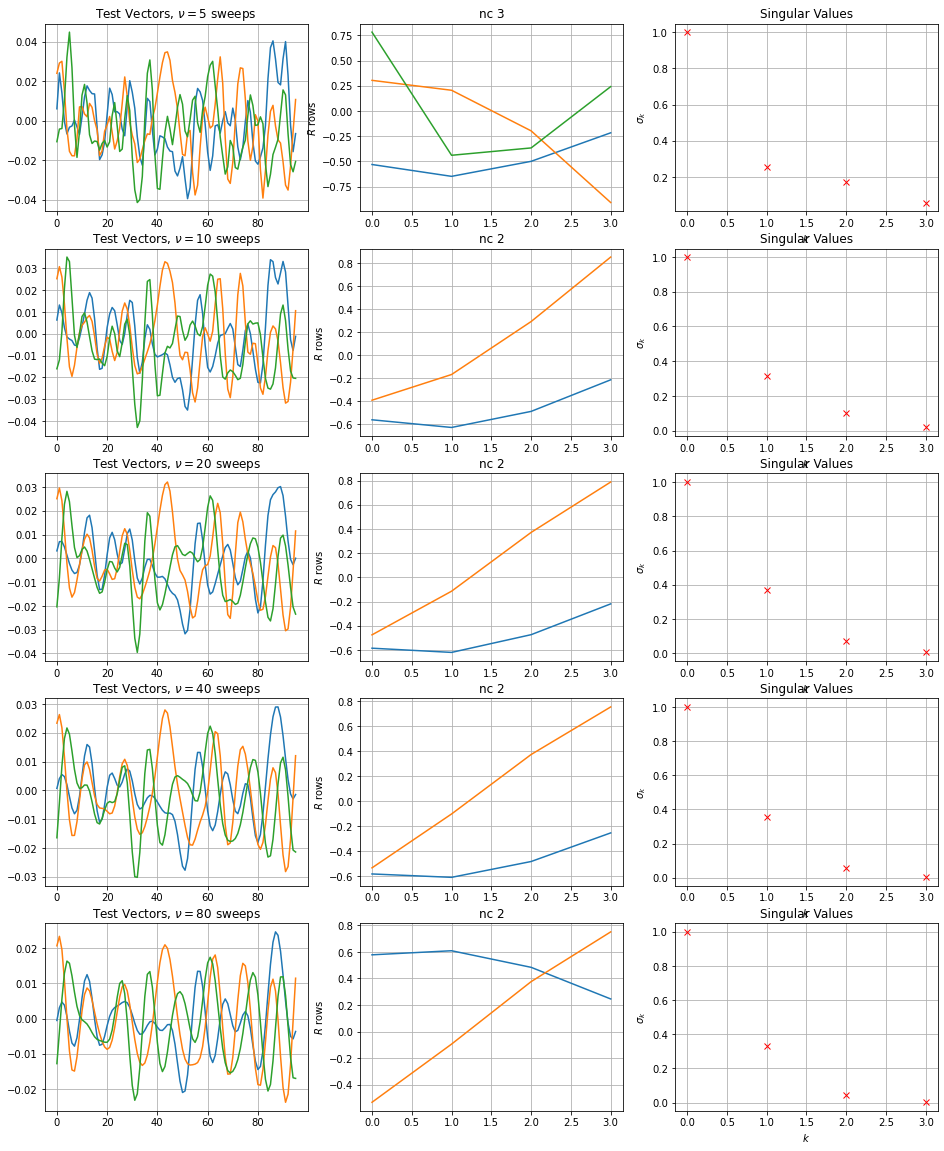

In [223]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hm.setup.hierarchy.create_finest_level(a)
x_random = hm.solve.run.random_test_matrix((n,), num_examples=num_examples)
b = np.zeros_like(x_random)

aggregate_size = 4
num_sweeps_values = 5 * 2 ** np.arange(5)

fig, axs = plt.subplots(len(num_sweeps_values), 3, figsize=(16, 4 * len(num_sweeps_values)))
for row, num_sweeps in enumerate(num_sweeps_values):
    # Create relaxed TVs.
    x = hm.solve.run.run_iterative_method(
        level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]

    start, end = 0, aggregate_size
    x_aggregate_t = x[start:end].transpose()
    r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()

    # # Create coarsening operator R.
    # r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_full_domain(
    #     x, threshold=threshold)
    # print(r.shape)
    # logger.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
    # logger.info("nc  {}".format(nc))
    # logger.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))

    # Relaxed vectors.
    ax = axs[row, 0]
    for i in range(3):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

    ax = axs[row, 1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title("nc {}".format(r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[row, 2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);
    
    print("nu", "{:2d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

The gap increases with $\nu$, showing that an aggregate size of $4$ is fine (we can obtain an energy error as small as we want given a large enough $\nu$).

## Smoothing Factor
Given an iterative method,
* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate the Residual to Error Ratio (RER) $r_i := \|A x_i\|_2 / \|x_i\|_2$ and the RER reduction factor per sweep, $c_i := r_i / r_{i-1}$, $i = 1, 2, \dots$.
* Average $c_i$ over the $5$ starts.
* Terminate the method after $n_{max}$ sweeps are reached, or $\mu_i > \mu_{max}$ (we use $n_{max} = 20, \mu_{max} = 1.1$).
* Fit a piecewise constant/power-law-with-intercept model in least-squares sesnse:
$$ c(n) = \mu_0, \qquad n \leq n_0\,, $$
$$ c(n) = \mu_{\infty} - (\mu_{\infty} - \mu_0) (\frac{n}{n_0})^p, \qquad n \geq n_0\,. $$
* The model depends on the parameters $\mu_0, n_0, \mu_{\infty}, p$. The **smoothing factor** is defined as $\mu_0$, the initial constant RER reduction, which is sustained for $n_0$ sweeps. Then the convegence is overtaken by smooth components; the asymptotic convergence factor estimate is $\mu_{\infty}$, and the power-law rate of reaching it is $p$ (which is negative).

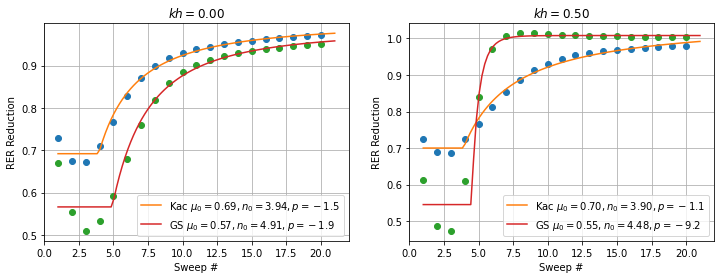

In [224]:
kh_values = [0, 0.5]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)

# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax in zip(("Kac", "GS"), (kaczmarz, gs)):
        p, conv = hm.solve.smoothing.shrinkage_factor(
            operator, relax(a_kh), (n, ), print_frequency=None, max_sweeps=20, slow_conv_factor=1.1)
        hm.solve.smoothing.plot_fitted_conv_model(p, conv, ax, title=title)

    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (in line with LFA at least for $kh = 0$), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

## Level 0->1: Two-level Coarsening + Bootstrapping

In [239]:
num_examples = 20
max_levels = 2
num_bootstrap_steps = 1
threshold = 0.1
interpolation_method = "ls"
num_sweeps = 10

_LOGGER = logger
x_log = {}

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros_like(x)
_, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), 
    hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples), num_sweeps=100)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))

# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log[1] = []
x_log[1].append(x)

_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log[1].append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
x_log[num_levels] = [x]
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 1,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold)
    x_log[num_levels].append(x)
    _LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)
x2 = x

INFO     Relax at level 0 size 96
INFO     Relax convergence factor 0.990
INFO     Generating TVs with 10 sweeps
INFO     RER 0.298
INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.994 asymptotic RQ 0.198 RER 0.237 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     Agg [8 4 4 4 4 4 4 4 4 4 4 4 8 4 4 4 4 4 4 4 4 4]
INFO     nc  [4 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2]
INFO     Energy error mean 0.0712 max 0.0924
INFO     Mock cycle conv factor [0.619 0.412 0.233 0.177 0.147 0.134 0.091 0.115 0.111 0.111 0.105]
INFO     P max error: fit 0.141 val 0.176 test 0.221; alpha mean 0.007
INFO     fit  set size 15 P error mean 0.02 max 0.04
INFO     test set size 5  P error mean 0.02 max 0.03
INFO     Level 1 size 47
INFO     RER 0.156
INFO     ---------------------------------------------

### Relaxation Cycle Smoothing
We compare relaxation cycle with $\nu_1=2, \nu_2=2, nu_{coarse}=4$ with the resulting $P$ and $R$ from the bootstrap step, with Kaczmarz relaxation.

Kaczmarz
INFO         0 |r| 3.04553826e+00 RER 3.04554
INFO         1 |r| 1.65202883e+00 (0.54244) RER 2.13373 (0.70061) 0.77425
INFO         2 |r| 9.33938673e-01 (0.56533) RER 1.37437 (0.64412) 0.67954
INFO         3 |r| 5.57776412e-01 (0.59723) RER 0.87674 (0.63793) 0.63619
INFO         4 |r| 3.65387193e-01 (0.65508) RER 0.59598 (0.67977) 0.61308
INFO         5 |r| 2.66638932e-01 (0.72974) RER 0.44569 (0.74783) 0.59826
INFO         6 |r| 2.10003050e-01 (0.78759) RER 0.35748 (0.80208) 0.58746
INFO         7 |r| 1.79246141e-01 (0.85354) RER 0.30962 (0.86612) 0.57892
INFO         8 |r| 1.59406894e-01 (0.88932) RER 0.27882 (0.90051) 0.57173
INFO         9 |r| 1.45130277e-01 (0.91044) RER 0.25666 (0.92054) 0.56545
INFO        10 |r| 1.34485928e-01 (0.92666) RER 0.24021 (0.93591) 0.55986
INFO        11 |r| 1.25929911e-01 (0.93638) RER 0.22699 (0.94494) 0.55479
INFO        12 |r| 1.18833723e-01 (0.94365) RER 0.21601 (0.95163) 0.55014
INFO        13 |r| 1.12851813e-01 (0.94966) RER 0.20675 (

/Users/olivne/helmholtz/src/helmholtz/solve/smoothing.py:68: RuntimeWarning: invalid value encountered in power
  lambda x: c - (c - y0)*(x / x0) ** p


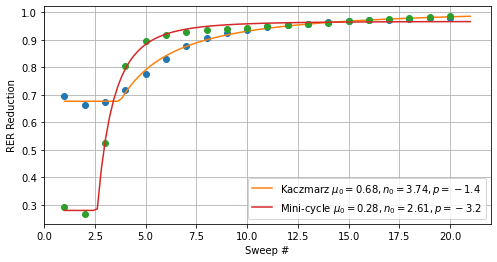

In [253]:
def relax_cycle(x):
    return hm.solve.relax_cycle.relax_cycle(multilevel, 1.0, 2, 2, 4, num_levels=num_levels).run(x)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

num_examples = 5
b = np.zeros((a.shape[0], num_examples))

operator = lambda x: a.dot(x)
relax = lambda x: level.relax(x, b)

for title, method in zip(("Kaczmarz", "Mini-cycle"), (relax, relax_cycle)):
    print(title)
    y, conv_factor = hm.solve.run.run_iterative_method(
        level.operator, method, hm.solve.run.random_test_matrix((level.size, ), num_examples=1), 
        30,  print_frequency=1)

    p, conv = hm.solve.smoothing.shrinkage_factor(
        operator, method, (n, ), print_frequency=None, max_sweeps=20, slow_conv_factor=0.99)
    hm.solve.smoothing.plot_fitted_conv_model(p, conv, ax, title=title)

ax.legend()
# y, conv_factor = hm.solve.run.run_iterative_method(
#     level.operator, relax_cycle, hm.solve.run.random_test_matrix((level.size, ), num_examples=1), 
#     10,  print_frequency=1)
# y_all[num_levels] = y
# print("Conv Factor {:.5f}".format(conv_factor))

The two-level relaxation cycle initially reduces the RER more efficiently than Kaczmarz, but not per unit work: the mini-cycle is $6$ relaxations worth, so its smoothing per unit relaxation sweep is estimated to be $0.28^{1/6} = 0.8$. However, it is able to obtain a much lower RER for the same amount of work (5 cycles / 30 Kaczmarz sweeps, see above printout). This just means that this particular smoothing factor estimate does not reflect the efficiency in RER reduction.

As expected, both methods are asymptotically slow (probably the same rate of convergence).